# Lesson 7: More Bayesian Data Analysis

## Intro to Quantified Cognition

## Lesson plan

- More Bayesian analysis examples
- Real-world data analysis in teams
- Intro to cognitive models


In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import pymc3 as pm
import theano.tensor as T

from sklearn import preprocessing

import dists

/home/per/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load and process the data

In [43]:
df = pd.read_csv('data/recog_data.csv')
df.head()

,subj,block,trial,stim_id,stim_class,stim_mem,stim_factor,resp_type,ac,rt
0,39,1,1,49_2.jpg,face,old,faceOld,tp,1,2027
1,39,1,2,6_2.jpg,flower,new,flowerNew,tn,1,1890
2,39,1,3,21_2.jpg,flower,new,flowerNew,tn,1,1367
3,39,1,5,49_2.jpg,flower,old,flowerOld,tp,1,1912
4,39,1,6,60_2.jpg,face,new,faceNew,fp,0,1708


In [44]:
# add some useful columns
df['log_rt'] = np.log(df['rt']/1000.)
df['stim'] = df['stim_class'] + '_' + df['stim_id']
df.head()

,subj,block,trial,stim_id,stim_class,stim_mem,stim_factor,resp_type,ac,rt,log_rt,stim
0,39,1,1,49_2.jpg,face,old,faceOld,tp,1,2027,0.706557,face_49_2.jpg
1,39,1,2,6_2.jpg,flower,new,flowerNew,tn,1,1890,0.636577,flower_6_2.jpg
2,39,1,3,21_2.jpg,flower,new,flowerNew,tn,1,1367,0.312619,flower_21_2.jpg
3,39,1,5,49_2.jpg,flower,old,flowerOld,tp,1,1912,0.648150,flower_49_2.jpg
4,39,1,6,60_2.jpg,face,new,faceNew,fp,0,1708,0.535323,face_60_2.jpg


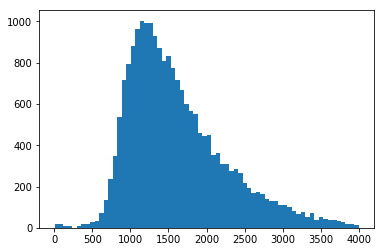

In [45]:
# show how distribution of log_rts is mostly normal
plt.hist(df['rt'].values, bins='auto');

In [46]:
# do some data cleaning
df = df[df['rt'] > 250]

In [47]:
# get various ways to index the data
# see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = preprocessing.LabelEncoder()
subj_idx = le.fit_transform(df['subj'])
class_idx = le.fit_transform(df['stim_class'])
stim_idx = le.fit_transform(df['stim'])
n_subj = len(df.subj.unique())
n_class = len(df.stim_class.unique())
n_stim = len(df.stim.unique())
print('# subj:', n_subj)
print('# class:', n_class)
print('# stim:', n_stim)

# subj: 184
# class: 2
# stim: 120


## Explore effects on reaction time

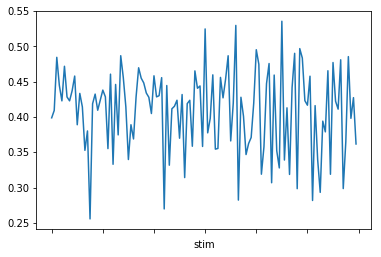

In [50]:
# show overall mean log_rt for each condition
df.groupby(['stim'])['log_rt'].mean().plot()

In [18]:
print('Overall mean:', df.log_rt.mean())
print('Overall std:', df.log_rt.std())

Overall mean: 0.4093801030334287
Overall std: 0.3798122203107784


### Hierarchical version of *t*-test

In [55]:
# define the hierarchical model
with pm.Model() as hierarchical_model:
    
    # hyperprior for mu
    mu_mu = pm.Normal('mu_mu', 
                        mu=df.log_rt.mean(), 
                        sd=df.log_rt.std()*2,
                        shape=n_class)
    sigma_mu = pm.HalfCauchy('sigma_mu', 10, shape=n_class)
    
    # prior on mu
    mu = pm.Normal('mu', mu_mu, sigma_mu, 
                   shape=(n_subj, n_class))
    
    # hyperprior for sd (Gelman suggests gamma prior)
    sd_scale = pm.Gamma('sd_scale', .5, .5,
                        shape=n_class)
    
    # prior on sd
    sd = pm.HalfCauchy('sd', sd_scale, 
                       shape=(n_subj, n_class))
    
    # prior on df (fixed for all params)
    nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    
    # hyperprior for mu_stim (highly constrained)
    mu_mu_stim = pm.Normal('mu_mu_stim',
                           mu=0.0,
                           sd=df.groupby(['stim'])['log_rt'].mean().std()*2)
    sigma_mu_stim = pm.HalfCauchy('sigma_mu_stim', 1)
    
    # prior on mu_stim
    mu_stim = pm.Normal('mu_stim', mu_mu_stim, sigma_mu_stim,
                        shape=n_stim)
    
    # likelihood
    log_rt_like = pm.StudentT('log_rt_like', 
                              mu=mu[subj_idx, class_idx] + mu_stim[stim_idx], 
                              sd=sd[subj_idx, class_idx],
                              nu=nu,
                              observed=df.log_rt)
    
    # save out some comparisons of interest
    mudiff01 = pm.Deterministic('mu_diff', mu_mu[1]-mu_mu[0])


/home/per/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


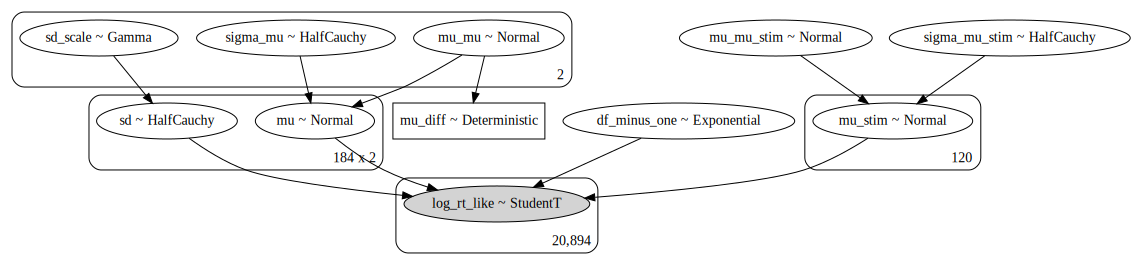

In [56]:
pm.model_to_graphviz(hierarchical_model)

In [57]:
with hierarchical_model:
    trace = pm.sample(2000, tune=5000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/per/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_stim, sigma_mu_stim, mu_mu_stim, df_minus_one, sd, sd_scale, mu, sigma_mu, mu_mu]
Sampling 2 chains: 100%|██████████| 14000/14000 [18:12<00:00, 12.81draws/s] 
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29284347555322365, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler

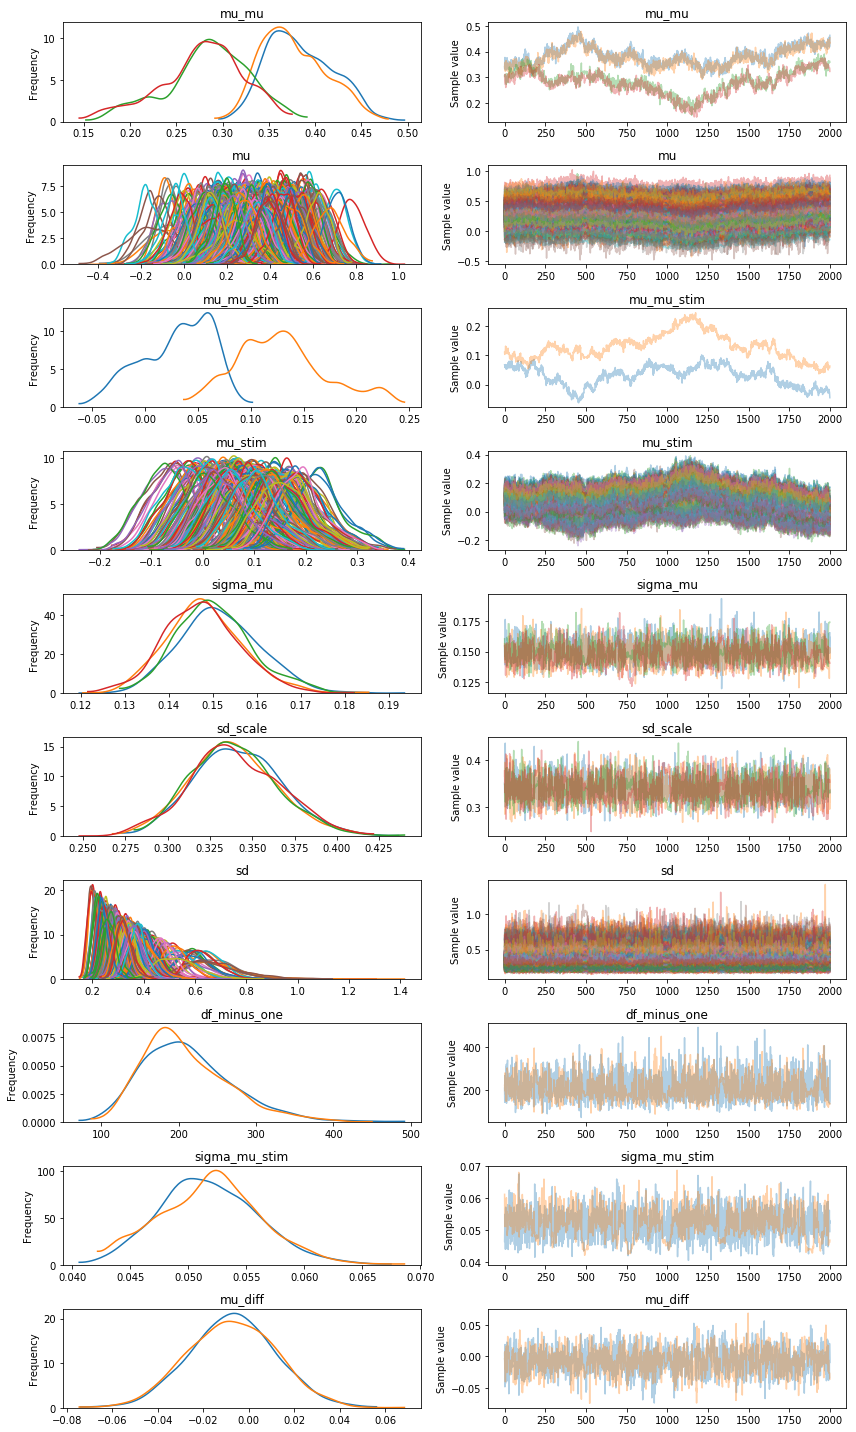

In [58]:
# check our traces
pm.traceplot(trace);

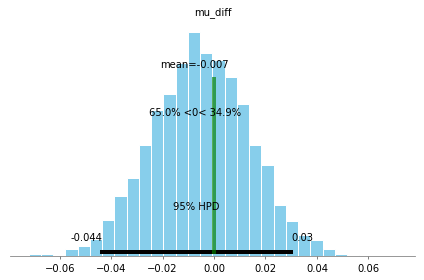

In [60]:
# show comparisons of interest
pm.plot_posterior(trace, varnames=['mu_diff'], 
                  ref_val=0.0);

## Hierarchical version of linear model with interaction terms

In [61]:
# load RDM data
df = pd.read_csv('data/rdm_dataframe.csv')
df.head()

,Unnamed: 0,correct,left_coherence,pressed,right_coherence,rt,subj,coherence
0,0,False,0.18,J,0.12,1.474685,101,"0.12, 0.18"
1,1,True,0.24,F,0.12,1.299920,101,"0.12, 0.24"
2,2,False,0.24,J,0.18,1.564434,101,"0.18, 0.24"
3,3,True,0.30,F,0.24,0.899411,101,"0.24, 0.3"
4,4,True,0.06,J,0.24,1.861133,101,"0.06, 0.24"


In [68]:
# add in coh_diff and min_coh columns
df['coh_diff'] = np.abs(df['left_coherence'] - df['right_coherence'])
df['min_coh'] = df[['left_coherence', 'right_coherence']].min(axis=1)
df['log_rt'] = np.log(df['rt'])

In [77]:
df = df[~np.isnan(df['rt'])]

In [78]:
# get various ways to index the data
# see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#
# Note, this must be performed AFTER any data culling
#
le = preprocessing.LabelEncoder()
subj_idx = le.fit_transform(df['subj'])
n_subj = len(df.subj.unique())
print('# subj:', n_subj)

# subj: 21


In [92]:
# define the hierarchical model
with pm.Model() as hierarchical_linear_model:
    # Hyperpriors for group nodes
    mu_inter = pm.Normal('mu_inter', mu=df.log_rt.mean(), sd=df.log_rt.std()*10)
    sigma_inter = pm.HalfCauchy('sigma_inter', 10)
    
    mu_slope_min = pm.Normal('mu_slope_min', mu=0., 
                             sd=df.log_rt.std()*10/(df['min_coh']).max())
    sigma_slope_min = pm.HalfCauchy('sigma_slope_min', 10)
    
    mu_slope_diff = pm.Normal('mu_slope_diff', mu=0., 
                              sd=df.log_rt.std()*10/(df['coh_diff']).max())
    sigma_slope_diff = pm.HalfCauchy('sigma_slope_diff', 10)
    
    mu_slope_minXdiff = pm.Normal('mu_slope_minXdiff', mu=0., 
                                  sd=df.log_rt.std()*10/(df['coh_diff']*df['min_coh']).max())
    sigma_slope_minXdiff = pm.HalfCauchy('sigma_slope_minXdiff', 10)

    # Intercept for each subj, distributed around group mean
    intercept = pm.Normal('intercept', mu=mu_inter, 
                          sd=sigma_inter, shape=n_subj)
    
    # slope for each subj, distributed around group mean
    slope_min = pm.Normal('slope_min', mu=mu_slope_min, 
                          sd=sigma_slope_min, shape=n_subj)
    slope_diff = pm.Normal('slope_diff', mu=mu_slope_diff, 
                           sd=sigma_slope_diff, shape=n_subj)
    slope_minXdiff = pm.Normal('slope_minXdiff', mu=mu_slope_minXdiff, 
                               sd=sigma_slope_minXdiff, shape=n_subj)

    # Model error
    eps = pm.HalfCauchy('eps', 10)
    
    # define the means predicted from a linear function
    log_rt_est = intercept[subj_idx] + \
                 slope_min[subj_idx] * df.min_coh.values + \
                 slope_diff[subj_idx] * df.coh_diff.values + \
                 slope_minXdiff[subj_idx] * df.min_coh.values * df.coh_diff.values
                 

    # Data likelihood (could also replace with Student's t)
    log_rt_like = pm.Normal('log_rt_like', 
                            mu=log_rt_est, 
                            sd=eps, 
                            observed=df.log_rt)
    
    # Data with Student's t likelihood
    # prior on df (fixed for all params)
    #nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    #log_rt_like = pm.StudentT('log_rt_like', mu=log_rt_est, sd=eps, nu=nu, observed=dat.log_rt)


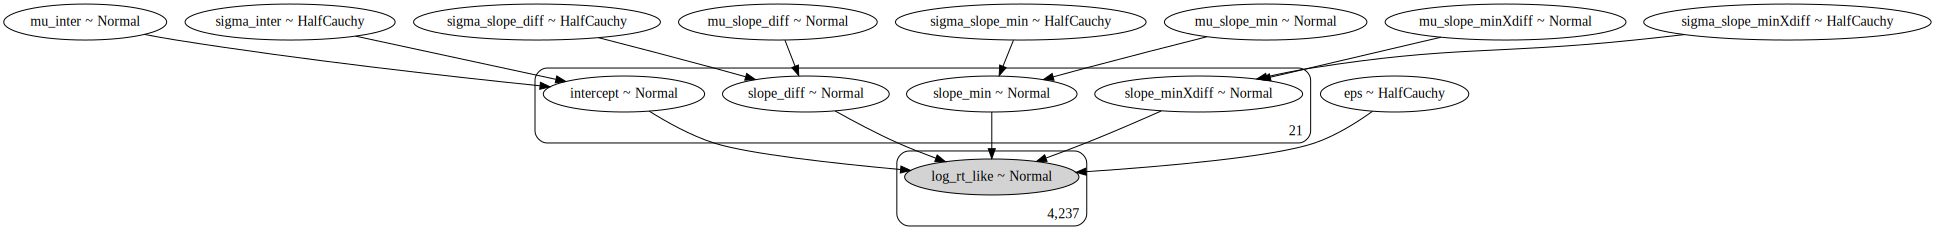

In [93]:
pm.model_to_graphviz(hierarchical_linear_model)

In [101]:
with hierarchical_linear_model:
    trace = pm.sample(2000, tune=2000, cores=2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, slope_minXdiff, slope_diff, slope_min, intercept, sigma_slope_minXdiff, mu_slope_minXdiff, sigma_slope_diff, mu_slope_diff, sigma_slope_min, mu_slope_min, sigma_inter, mu_inter]
Sampling 2 chains: 100%|██████████| 8000/8000 [03:44<00:00, 14.59draws/s] 
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8359530726374066, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


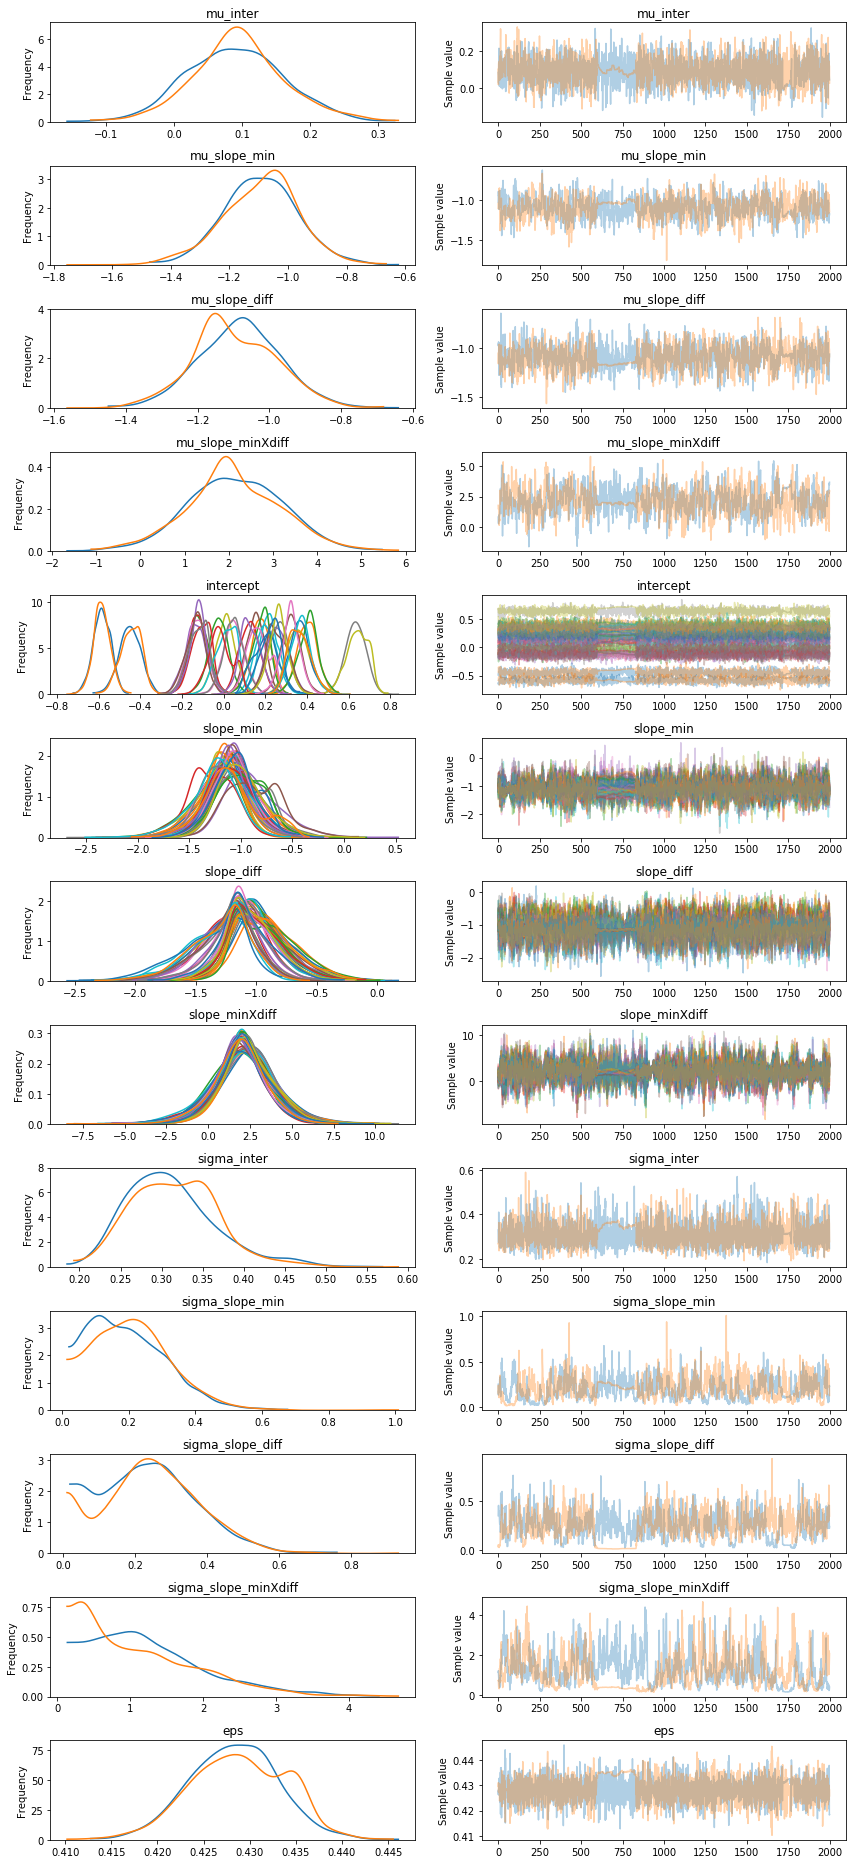

In [102]:
pm.traceplot(trace);

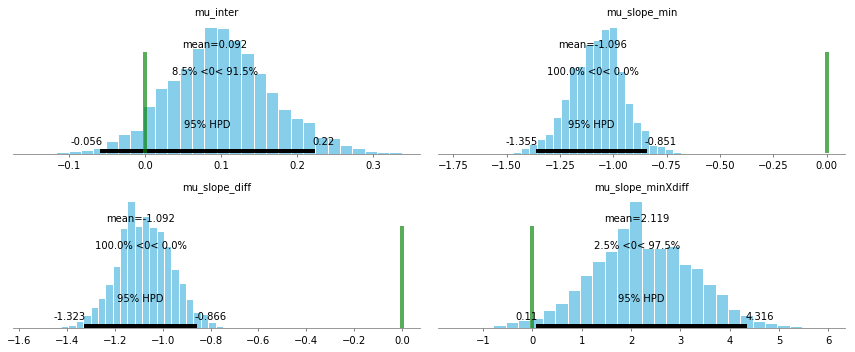

In [103]:
pm.plot_posterior(trace, varnames=['mu_inter', 'mu_slope_min', 'mu_slope_diff', 'mu_slope_minXdiff'], 
                  ref_val=0.0);

In [104]:
with hierarchical_linear_model:
    print(pm.waic(trace))
    

WAIC_r(WAIC=4878.233165804327, WAIC_se=238.69796147435778, p_WAIC=44.77655753273755, var_warn=1)


/home/per/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [106]:
# define the hierarchical model (no interaction term)
with pm.Model() as hierarchical_linear_model:
    # Hyperpriors for group nodes
    mu_inter = pm.Normal('mu_inter', mu=df.log_rt.mean(), sd=df.log_rt.std()*10)
    sigma_inter = pm.HalfCauchy('sigma_inter', 10)

    mu_slope_min = pm.Normal('mu_slope_min', mu=0., 
                             sd=df.log_rt.std()*10/(df['min_coh']).max())
    sigma_slope_min = pm.HalfCauchy('sigma_slope_min', 10)
    
    mu_slope_diff = pm.Normal('mu_slope_diff', mu=0., 
                              sd=df.log_rt.std()*10/(df['coh_diff']).max())
    sigma_slope_diff = pm.HalfCauchy('sigma_slope_diff', 10)
    
    #mu_slope_minXdiff = pm.Normal('mu_slope_minXdiff', mu=0., 
    #                              sd=df.log_rt.std()*10/(df['coh_diff']*df['min_coh']).max())
    #sigma_slope_minXdiff = pm.HalfCauchy('sigma_slope_minXdiff', 10)

    # Intercept for each subj, distributed around group mean
    intercept = pm.Normal('intercept', mu=mu_inter, 
                          sd=sigma_inter, shape=n_subj)
    
    # slope for each subj, distributed around group mean
    slope_min = pm.Normal('slope_min', mu=mu_slope_min, 
                          sd=sigma_slope_min, shape=n_subj)
    slope_diff = pm.Normal('slope_diff', mu=mu_slope_diff, 
                           sd=sigma_slope_diff, shape=n_subj)
    #slope_minXdiff = pm.Normal('slope_minXdiff', mu=mu_slope_minXdiff, 
    #                           sd=sigma_slope_minXdiff, shape=n_subj)

    # Model error
    eps = pm.HalfCauchy('eps', 10)
    
    # define the means predicted from a linear function
    log_rt_est = intercept[subj_idx] + \
                 slope_min[subj_idx] * df.min_coh.values + \
                 slope_diff[subj_idx] * df.coh_diff.values # + \
                 #slope_minXdiff[subj_idx] * df.min_coh.values * df.coh_diff.values
                 

    # Data likelihood (could also replace with Student's t)
    log_rt_like = pm.Normal('log_rt_like', 
                            mu=log_rt_est, 
                            sd=eps, 
                            observed=df.log_rt)
    
    # Data with Student's t likelihood
    # prior on df (fixed for all params)
    #nu = pm.Exponential('df_minus_one', 1/29.) + 1.
    #log_rt_like = pm.StudentT('log_rt_like', mu=log_rt_est, sd=eps, nu=nu, observed=dat.log_rt)


In [107]:
with hierarchical_linear_model:
    trace = pm.sample(2000, tune=2000, cores=2, nuts_kwargs=dict(target_accept=.90))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, slope_diff, slope_min, intercept, sigma_slope_diff, mu_slope_diff, sigma_slope_min, mu_slope_min, sigma_inter, mu_inter]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:50<00:00, 72.15draws/s] 
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7573431394240177, but should be close to 0.9. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


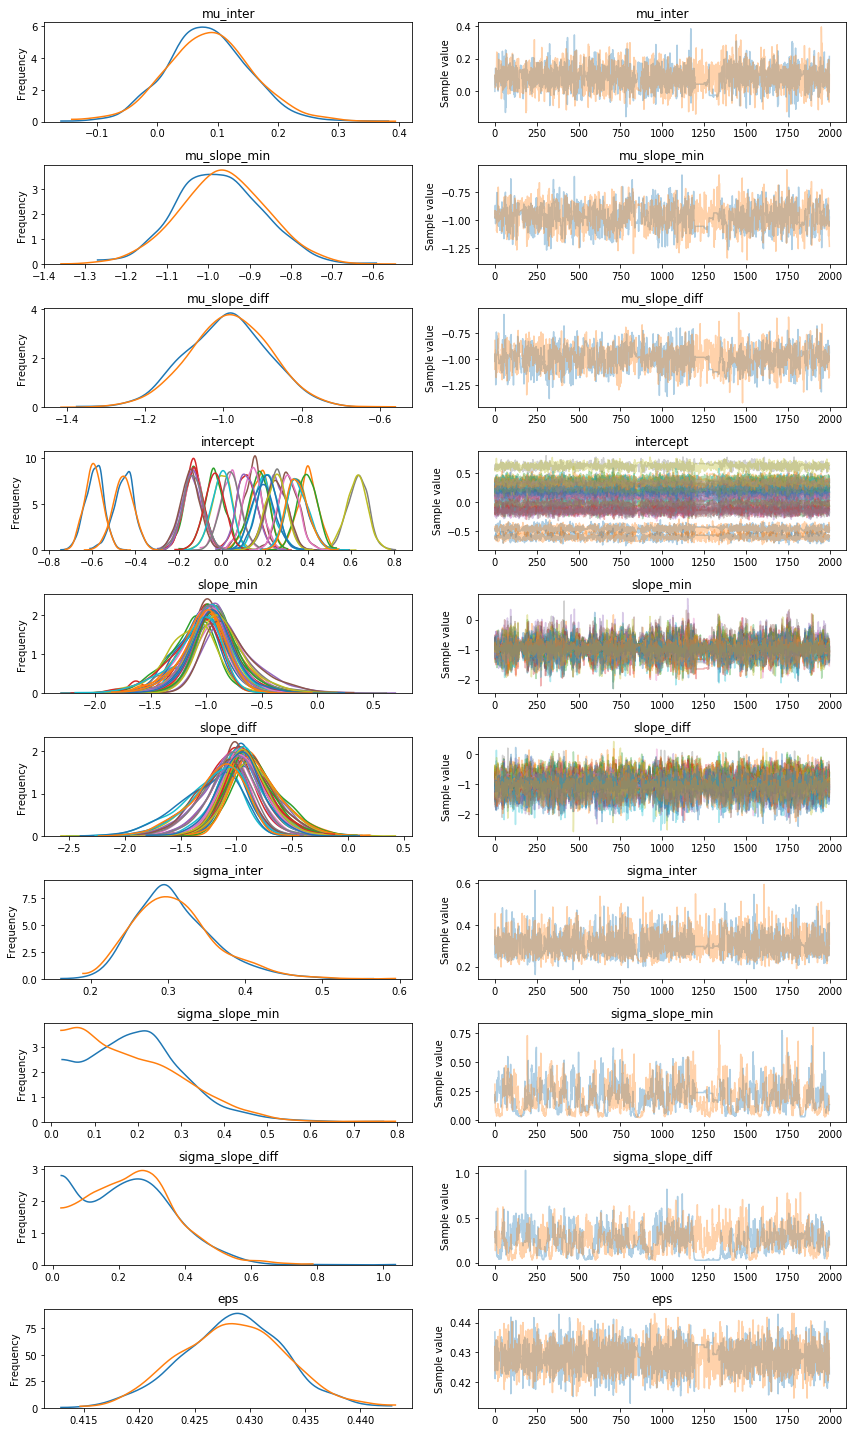

In [108]:
pm.traceplot(trace);

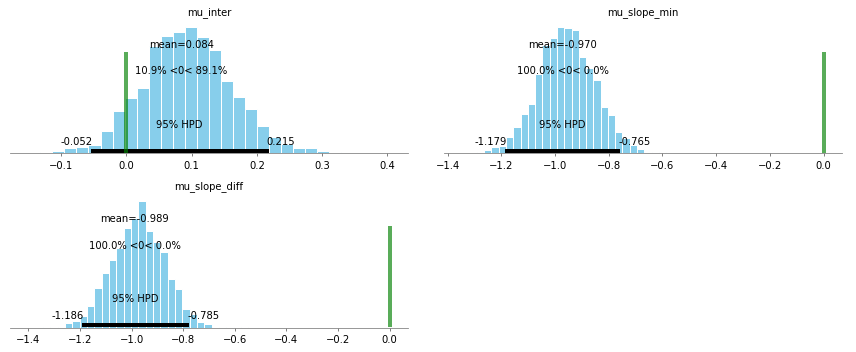

In [109]:
pm.plot_posterior(trace, varnames=['mu_inter', 'mu_slope_min', 'mu_slope_diff'], 
                  ref_val=0.0);

In [110]:
with hierarchical_linear_model:
    print(pm.waic(trace))
    

WAIC_r(WAIC=4877.009799835547, WAIC_se=238.58405786063665, p_WAIC=40.30474969784335, var_warn=1)


/home/per/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
